# Analysis demo notebook

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from tasks import SequenceInstructedTask
from models.rnn import RNN
from analysis import (
    generate_data,
    do_pca,
    visualize_pca,
    plot_cross_period_variance,
)

plt.rcParams["figure.dpi"] = 100

## Setup: Load Model and Generate Data

In [2]:
checkpoint_path = "logs/transition_to_inferred/checkpoint_step_3200.pt"

print(f"Loading checkpoint from: {checkpoint_path}")
checkpoint = torch.load(checkpoint_path, map_location="cpu")

# task = InstructedTimingTask(w_m=0.05, input_noise_std=0.05)
task = SequenceInstructedTask(w_m=0.05, input_noise_std=0.05, trials_per_sequence=40)

model = RNN(
    hidden_size=256,
    noise_std=0.0,  # No noise during evaluation
)

# Load trained weights
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print(f"Loaded model from step {checkpoint['step']}")
print(f"Model: {model.hidden_size} hidden units")
print(f"Task: {task.trials_per_sequence} trials per sequence")

# Generate data with reward feedback
print("Generating data...")
data_dict = generate_data(task, model, num_trials=80)
rules = np.array(
    [
        data_dict["batch"][i]["metadata"]["rule"][0]
        for i in range(len(data_dict["batch"]))
    ]
)
print(f"Rule 1 count: {(rules == 1).sum()}, Rule 2 count: {(rules == -1).sum()}")

Loading checkpoint from: logs/transition_to_inferred/checkpoint_step_3200.pt
Loaded model from step 3200
Model: 256 hidden units
Task: 40 trials per sequence
Generating data...
Rule 1 count: 27, Rule 2 count: 53


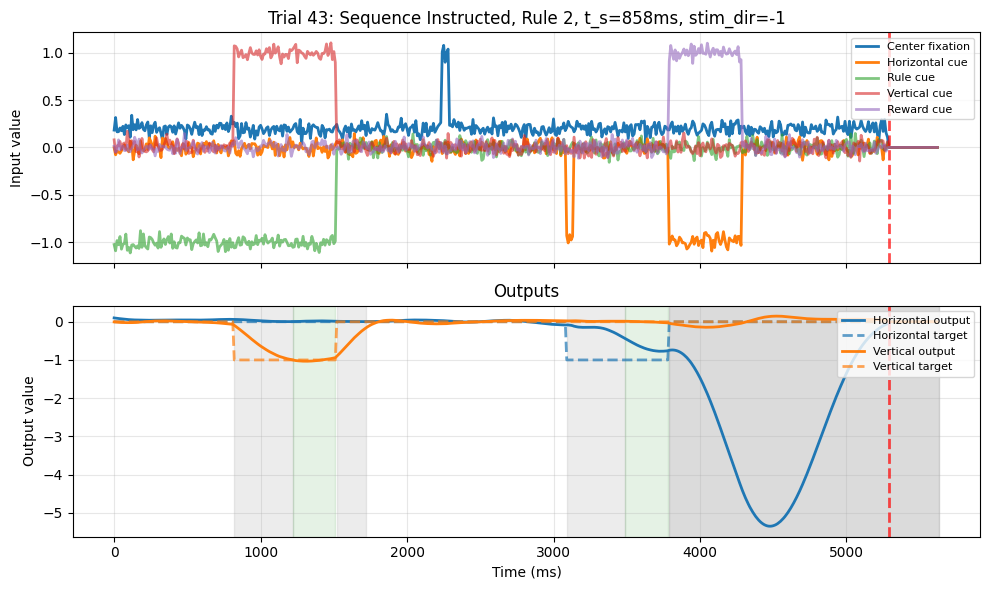

In [13]:
# Plot random trial
batch = data_dict["batch"]
outputs = data_dict["outputs"]
trial_idx = np.random.randint(0, len(batch))  # sample random trial
# trial_idx = 74
trial_outputs = outputs[trial_idx].numpy()
trial_inputs = batch[trial_idx]["inputs"][0].numpy()
trial_targets = batch[trial_idx]["targets"][0].numpy()
trial_eval_mask = batch[trial_idx]["eval_mask"][0].numpy()
trial_loss_mask = batch[trial_idx]["loss_mask"][0].numpy()

# Create figure using task method
fig = task.create_trial_figure(
    inputs=trial_inputs,
    outputs=trial_outputs,
    targets=trial_targets,
    eval_mask=trial_eval_mask,
    trial_idx=trial_idx,
    batch=batch,
    batch_idx=0,
    loss_mask=trial_loss_mask,
)

## Do PCA. Combine projections, event segments, periods.

PCA data shape: (80, 563, 3)
Axis: ['PC1 (58.2% var)', 'PC2 (11.6% var)', 'PC3 (9.4% var)']


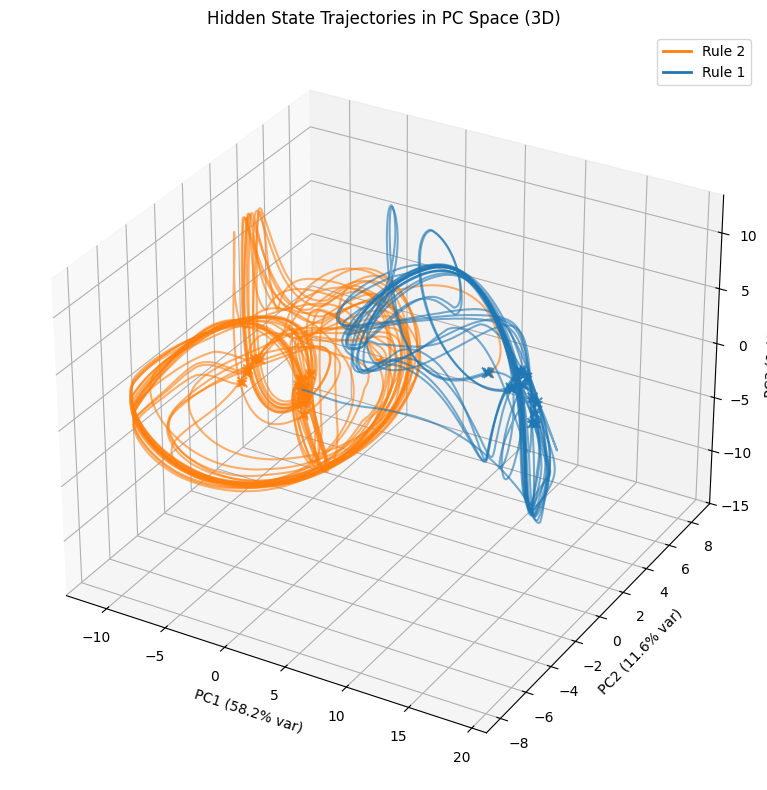

In [10]:
# Run PCA on full trajectories
result_full = do_pca(
    data_dict,
    task,
    # periods=['timing','decision'],
    # projection=['output_dim_0'],
    model=model,
    n_components=3,
)

segments = [
    {
        "start": "timing_start",
        "end": "first_pulse",
        "alpha": 0.2,
        "label": "Pre-first pulse",
    },
    {
        "start": "first_pulse",
        "end": "decision_start",
        "alpha": 1.0,
        "label": "Interval timing",
    },
    {"start": "decision_start", "end": "trial_end", "alpha": 0.8, "label": "Decision"},
]

print(f"PCA data shape: {result_full['pca_data'].shape}")
print(f"Axis: {result_full['axis_labels']}")

plot = visualize_pca(
    result_full,
    plot_3d=True,
    # segments=segments,
    num_trials=40,
    color_by="rule",
)

# from IPython.display import HTML
# HTML(plot.to_html5_video()) # replace visualize_pca by animate_pca

## Cross-Period Variance

How well do PCs from one period explain variance in other periods?

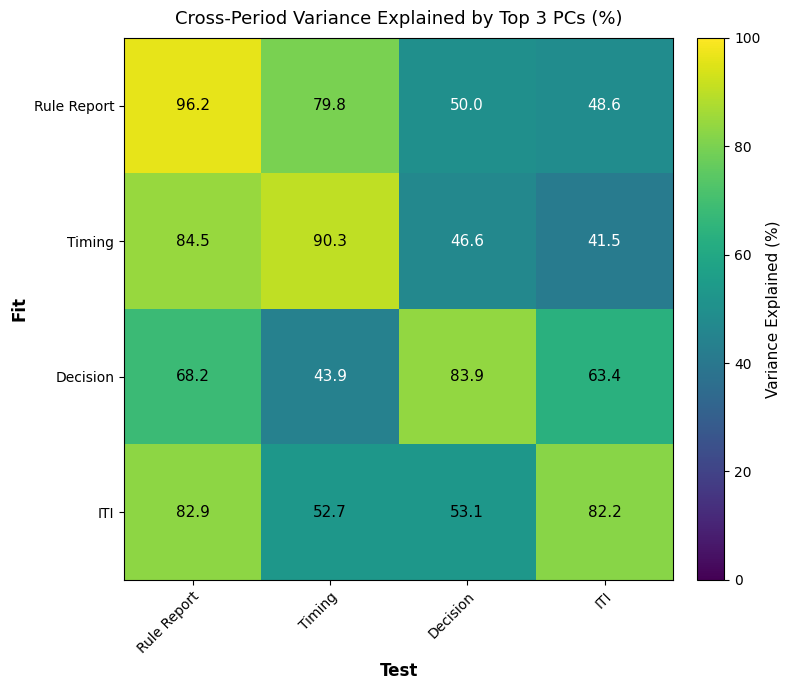

In [5]:
fig, ax = plot_cross_period_variance(
    data_dict,
    task=task,
    n_components=3,
)

## Psychometric Function

P(Anti saccade) vs interval duration for each rule.

In [6]:
from analysis import compute_psychometric_curves

# Compute psychometric curves for both rules
results = compute_psychometric_curves(
    task, model, num_trials_per_interval=100, rules=[1, -1]
)

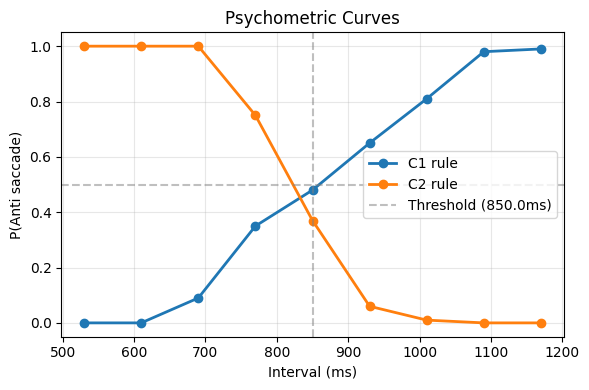

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for rule in [1, -1]:
    rule_label = "C1" if rule == 1 else "C2"
    anti_probs = results["anti_probs"][rule]
    ax.plot(
        results["intervals"],
        anti_probs,
        marker="o",
        label=f"{rule_label} rule",
        linewidth=2,
    )

ax.axhline(0.5, color="gray", linestyle="--", alpha=0.5)
ax.axvline(
    task.decision_threshold,
    color="gray",
    linestyle="--",
    alpha=0.5,
    label=f"Threshold ({task.decision_threshold}ms)",
)
ax.set_xlabel("Interval (ms)")
ax.set_ylabel("P(Anti saccade)")
ax.set_title("Psychometric Curves")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Variance Explained

How many principal components are needed to capture neural variance?

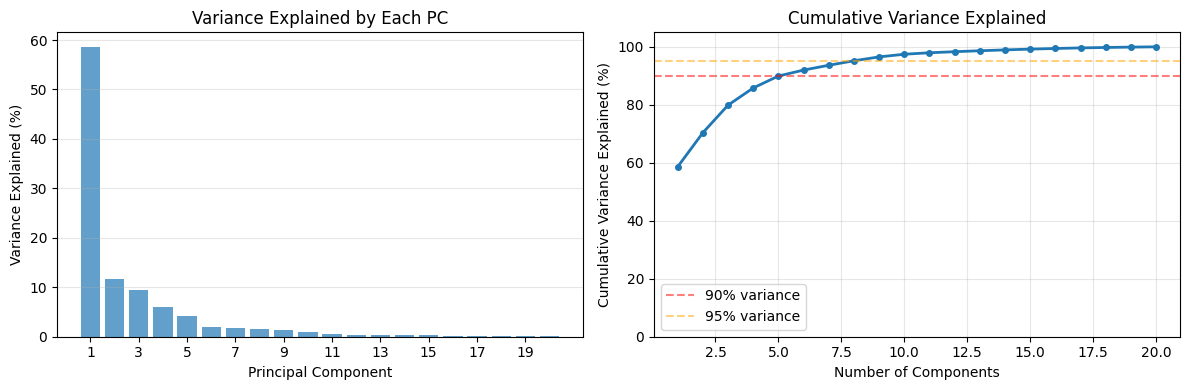

Components needed for 90% variance: 6
Components needed for 95% variance: 8

Top 5 PCs explain: 89.9% of variance
Top 10 PCs explain: 97.4% of variance


In [8]:
# Perform PCA with many components to analyze dimensionality
result_dims = do_pca(data_dict, task, periods="all", n_components=20)

# Extract variance explained
var_explained = result_dims["explained_variance"]
var_explained_pct = 100 * var_explained / var_explained.sum()
cumulative_var = np.cumsum(var_explained_pct)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot of variance explained
ax = axes[0]
x = np.arange(1, len(var_explained_pct) + 1)
ax.bar(x, var_explained_pct, alpha=0.7)
ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
ax.set_title("Variance Explained by Each PC")
ax.set_xticks(x[::2])  # Show every other tick
ax.grid(True, alpha=0.3, axis="y")

# Cumulative variance plot
ax = axes[1]
ax.plot(x, cumulative_var, marker="o", linewidth=2, markersize=4)
ax.axhline(90, color="red", linestyle="--", alpha=0.5, label="90% variance")
ax.axhline(95, color="orange", linestyle="--", alpha=0.5, label="95% variance")
ax.set_xlabel("Number of Components")
ax.set_ylabel("Cumulative Variance Explained (%)")
ax.set_title("Cumulative Variance Explained")
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 105])

plt.tight_layout()
plt.show()

# Print summary statistics
n_90 = np.argmax(cumulative_var >= 90) + 1
n_95 = np.argmax(cumulative_var >= 95) + 1
print(f"Components needed for 90% variance: {n_90}")
print(f"Components needed for 95% variance: {n_95}")
print(f"\nTop 5 PCs explain: {cumulative_var[4]:.1f}% of variance")
print(f"Top 10 PCs explain: {cumulative_var[9]:.1f}% of variance")

## Helper: clear all plots

In [9]:
plt.close("all")